In [1]:
# Thêm thư viện
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

In [2]:
import os
os.chdir('D:/HUST/AI/Buffer Training/')
print("Ok")

Ok


In [3]:
# Lấy dữ liệu từ bộ MNIST
(X_train, _), (X_test, _) = mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

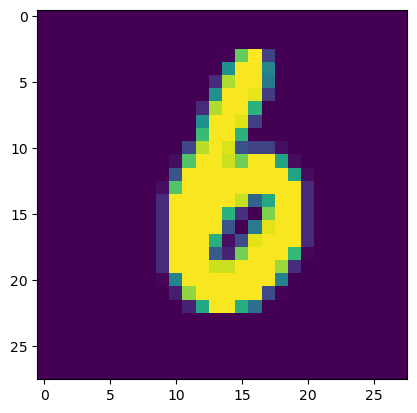

In [5]:
idx_random = random.randint(0, 60000)
plt.imshow(X_train[idx_random])

In [6]:
#Tiền xử lý dữ liệu, chuyển hình ảnh đầu vào thành 1 chiều và chuẩn hóa thành 0 -> 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train.shape

(60000, 784)

In [7]:
#Số chiều của vector 
z_dim = 100

#Optimizer
adam = Adam(learning_rate=0.0002, beta_1=0.5)

print("OK")

OK


In [8]:
#Bộ sinh Generator: sinh ảnh giả từ vector ngẫu nhiên
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(X_train.shape[1], activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

print("OK")


OK


In [9]:
#Bộ kiểm duyệt Discriminator: kiểm định ảnh thật giả, ảnh thật -> 1, ảnh giả -> 0
d = Sequential()
d.add(Dense(1024, input_dim=X_train.shape[1], activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))

# Hàm sigmoid cho bài toán binary classification
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

print("OK")


OK


In [10]:
# Mô hình tổng hợp 
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

print("OK")

OK


In [11]:
# Hàm vẽ loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
print("OK")

OK


In [12]:
# Hàm vẽ sample từ Generator
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("OK")

OK


In [13]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D": [], "G": []}


In [16]:
def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    HALF_BATCH_SIZE = BATCH_SIZE // 2
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Lấy 1 batch ngẫu nhiên từ tập hình ảnh đầu vào
            img_real = X_train[np.random.randint(0, X_train.shape[0], size=HALF_BATCH_SIZE)]

            # Sinh ra 1 batch vector ngẫu nhiên làm đầu vào 
            noise = np.random.normal(0, 1, size=(HALF_BATCH_SIZE, z_dim))

            # Dùng bộ generator sinh ra 1 batch hình ảnh ngẫu nhiên
            img_fake = g.predict(noise)

            # Tạo label cho ảnh thật và ảnh giả
            y_real = np.ones(HALF_BATCH_SIZE)
            y_fake = np.zeros(HALF_BATCH_SIZE)

            # Huấn luyện bộ discriminator
            d.trainable = True # Bật cập nhật tham số bộ discriminator
            d_loss_real = d.train_on_batch(img_real, y_real)
            d_loss_fake = d.train_on_batch(img_fake, y_fake)
            d_loss = [(d_loss_real[0] + d_loss_fake[0])/2, (d_loss_real[1] + d_loss_fake[1])/2]

            # Huấn luyện bộ generator
            # Sinh ra 1 batch vector ngẫu nhiên làm đầu vào 
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y_real_g = np.ones(BATCH_SIZE)
            d.trainale = False # Tắt cập nhật tham số bộ discriminator
            g_loss = gan.train_on_batch(noise, y_real_g)

        # Lưu loss_function 
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả 
        if e == 1 or e%plt_frq == 0:
            plot_generated()
            
    plot_loss(losses)
    
print("OK")

OK


Epochs: 200
Batch size: 128
Batches per epoch: 468


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
1/1 [==============================] - 0s 76ms/step


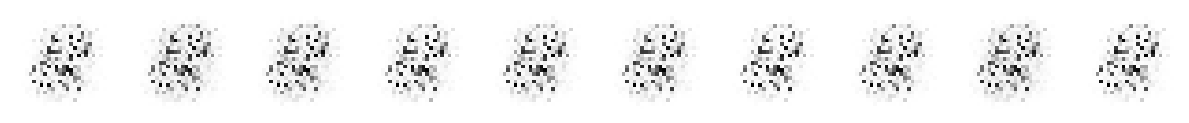

2/2 [==============================] - 0s 2ms/step


In [ ]:
# Train GAN models
train(epochs=200, plt_frq=20, BATCH_SIZE=128)